# Modeling the Olfactory Bulb and its Neural Oscillatory Processings
### (1989: Li & Hopfield.)

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Initial Parameters

In [170]:
# ideally M:N = 200:1
N = 10 # excitatory mitral
M = 10 # inhibitory granule

t_total = 400
t_inhale = 0
t_exhale = 200
tau_exhale = 33

cycles = 3

### Inputs

[0 0 7 0 0 0 0 0 0 0]


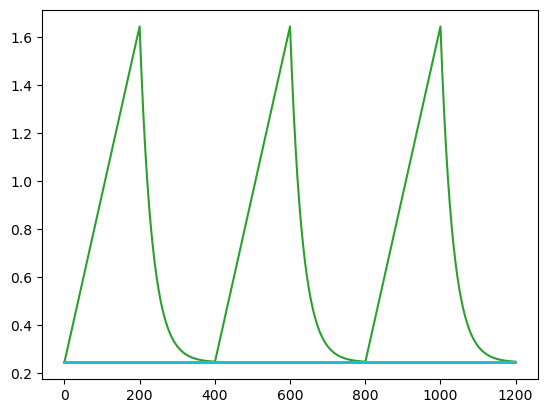

In [171]:
# background input
I_bg = 0.243 # make random
P = 7 * np.random.binomial(1, .2, N) # small fraction is 1

print(P)

# mitral cell inputs
I_odor = np.zeros((cycles * t_total, N))  # t x N
for c in range(cycles):
    for i in range(N):
        P_odor = P[i] # (!) strange behavior in G(X) even if set to 0 
        for j in range(t_total):
            if j >= t_inhale and j <= t_exhale:
                I_odor[j + t_total * c][i] += P_odor * (j - t_inhale)/1000 + I_odor[t_inhale][i]
            if j > t_exhale:
                I_odor[j + t_total * c][i] = I_odor[t_exhale][i] * \
                    pow(np.e, -(j-t_exhale)/tau_exhale)
I = (I_odor + I_bg)

# granule cell inputs
I_c = 0.12

plt.plot(I)
plt.show()

### Synaptic Connections

In [172]:
H_0 = np.zeros((N, M))  # H[i,j] = jth granule --> ith mitral
W_0 = np.zeros((M, N))  # mitral --> granule

# not loving the structure of these matrices, maybe should just assume 10x10
for i in range(N):
    for j in range(M):
        H_diag = i * M / N
        W_diag = j * N / M
        if (j == H_diag):
            H_0[i, j] = np.random.uniform(low=0.3, high=0.5)
        elif (j == H_diag + 1) or (j == H_diag - 1) or (i - j == N - 1) or (j - i == M - 1): 
            H_0[i, j] = np.random.uniform(low=0.5, high=1.)

        if (i == W_diag):
            W_0[j, i] = np.random.uniform(low=0.3, high=0.5)
        elif (i == W_diag + 1) or (i == W_diag - 1) or (i - j == N - 1) or (j - i == M - 1) or (j > i and np.random.uniform() < 0.1):
            W_0[j, i] = np.random.uniform(low=0.5, high=1.)

df = pd.DataFrame(W_0)
df.to_csv('out_li.csv', index=False)

Sample matrices given for N = 10, M = 10

In [173]:
H_sample = np.array([[0.3, 0.9, 0, 0, 0, 0, 0, 0, 0, 0.7], \
                     [0.9, 0.4, 1, 0, 0, 0, 0, 0, 0, 0], \
                     [0, 0.8, 0.3, 0.8, 0, 0, 0, 0, 0, 0], \
                     [0, 0, 0.7, 0.5, 0.9, 0, 0, 0, 0, 0], \
                     [0, 0, 0, 0.8, 0.3, 0.8, 0, 0, 0, 0], \
                     [0, 0, 0, 0, 0.7, 0.3, 0.9, 0, 0, 0], \
                     [0, 0, 0, 0, 0, 0.7, 0.4, 0.9, 0, 0], \
                     [0, 0, 0, 0, 0, 0, 0.5, 0.5, 0.7, 0], \
                     [0, 0, 0, 0, 0, 0, 0, 0.9, 0.3, 0.9], \
                     [0.9, 0, 0, 0, 0, 0, 0, 0, 0.8, 0.3]])

W_sample = np.array([[0.3, 0.7, 0, 0, 0, 0, 0, 0, 0.5, 0.3],
                     [0.3, 0.2, 0.5, 0, 0, 0, 0, 0, 0, 0.7], 
                     [0, 0.1, 0.3, 0.5, 0, 0, 0, 0, 0, 0], 
                     [0, 0.5, 0.2, 0.2, 0.5, 0, 0, 0, 0, 0], 
                     [0.5, 0, 0, 0.5, 0.1, 0.9, 0, 0, 0, 0], 
                     [0, 0, 0, 0, 0.3, 0.3, 0.5, 0.4, 0, 0], 
                     [0, 0, 0, 0.6, 0, 0.2, 0.3, 0.5, 0, 0], 
                     [0, 0, 0, 0, 0, 0, 0.5, 0.3, 0.5, 0], 
                     [0, 0, 0, 0, 0, 0.2, 0, 0.2, 0.3, 0.7], 
                     [0.7, 0, 0, 0, 0, 0, 0, 0.2, 0.3, 0.5]])


### Internal State Cell Models

In [174]:
X = np.zeros((cycles * t_total, N)) # mitral cell internal states
Y = np.zeros((cycles * t_total, M))  # granule cell internal state

# internal states
X_out = np.zeros((cycles * t_total, N)) # mitral cell output states
Y_out = np.zeros((cycles * t_total, M))  # granule cell output state

th = 1
Sx, Sx_prime = 1.4, 0.14
Sy, Sy_prime = 2.9, 0.29

def G_x(v, i):
    out = np.array([Sx_prime + Sx_prime *
                    np.tanh((x-th)/Sx_prime) if x < th else Sx_prime + Sx*np.tanh((x-th)/Sx) for x in v])
    X_out[i, :] = out
    return out

def G_y(v, i):
    out =  np.array([Sy_prime + Sy_prime *
                     np.tanh((y-th)/Sy_prime) if y < th else Sy_prime + Sy*np.tanh((y-th)/Sy) for y in v])
    Y_out[i, :] = out
    return out

Bulb models

In [175]:
tau_x, tau_y = 7, 7
alpha_x, alpha_y = 1/tau_x, 1/tau_y

for t in range(cycles * t_total):
    # mitral
    # X_dot = -H_0@G_y(Y[t-1, :], t) - alpha_x*X[t-1, :] + I[t]
    X_dot = -H_sample@G_y(Y[t-1, :], t) - alpha_x*X[t-1, :] + I[t]
    X[t, :] = X[t-1, :] + X_dot
    # granule
    # Y_dot = W_0@G_x(X[t-1, :], t) - alpha_y*Y[t-1, :] + I_c
    Y_dot = W_sample@G_x(X[t-1, :], t) - alpha_y*Y[t-1, :] + I_c
    Y[t, :] = Y[t-1, :] + Y_dot


### Graphing

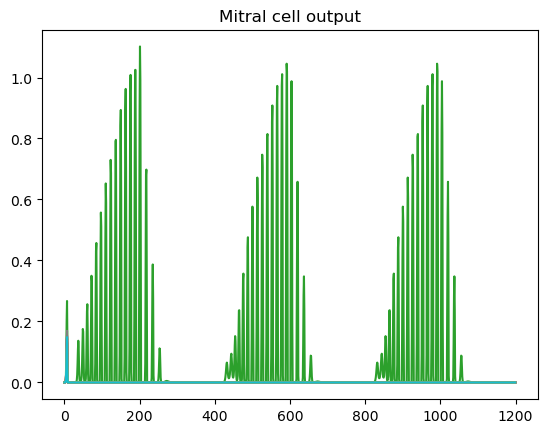

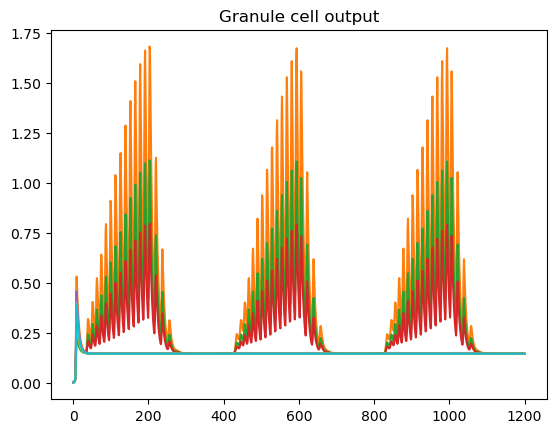

In [176]:
# Mitral Output
plt.plot(X_out[:, :])
plt.title('Mitral cell output')
plt.show()

# Granule Output
plt.plot(Y_out[:, :])
plt.title('Granule cell output')
plt.show()

# df = pd.DataFrame(X_out, columns = [f"Cell {i+1}" for i in range(N)], index=[i for i in range(cycles * t_total)])
# df.to_csv('out_li.csv')
